<a href="https://colab.research.google.com/github/taaha3244/AI-Agents/blob/main/langraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core qdrant-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.7/202.7 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.8/332.8 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.1/230.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.5/327.5 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [8]:
from google.colab import userdata
import os
from qdrant_client import QdrantClient
from langchain.document_loaders import PDFPlumberLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores.qdrant import Qdrant
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from typing import List,Optional,Type
from langchain import hub
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langchain.pydantic_v1 import BaseModel, Field
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI
import functools
from langchain_core.messages import AIMessage

In [3]:
openai_api_key=userdata.get('openai_api_key')

In [4]:
def create_agent(llm, tools=None, system_message: str = None):
    """Create an agent."""
    tool_names = ", ".join([tool.name for tool in tools]) if tools else "None"
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message, tool_names=tool_names)
    if tools:
        return prompt | llm.bind_tools(tools)
    else:
        return prompt | llm

In [58]:
class reportToolInput(BaseModel):
    query: List[str] = Field(description="A list of inputs for the RAG pipeline")

class reportTool(BaseTool):
    name: str = "report_tool"  # Ensure the name conforms to the expected pattern
    description: str = "Tool to retrieve relevant documents from the vector database using a list of user queries and return a response."
    args_schema: Optional[Type[BaseModel]] = reportToolInput
    return_direct: bool = True

    def _run(self, query: List[str]) -> str:
        try:
            # Setup
            qdrant_end = userdata.get('qdrant_end')
            qdrant_api_key = userdata.get('qdrant')
            openai_api_key = userdata.get('openai_api_key')

            embeddings_model = OpenAIEmbeddings(model='text-embedding-ada-002', openai_api_key=openai_api_key)
            qdrant_client = QdrantClient(url=qdrant_end, api_key=qdrant_api_key)
            qdrant = Qdrant(client=qdrant_client, collection_name="policy-agent", embeddings=embeddings_model)
            retriever = qdrant.as_retriever(search_kwargs={"k": 3})
            responses = []
            for q in query:
                response = retriever.invoke(q)
                responses.append(str(response))

            return responses

        except Exception as e:
            return f"Error processing the query: {e}"

In [46]:
a=reportTool()

In [56]:
b=a._run(['what is LIHTC','what is fees?'])

In [57]:
b

['[Document(page_content=\'Introduction and Authority\\nThe Tax Reform Act of 1986 established the Federal Low Income Housing Tax Credit (LIHTC)\\n1\\nProgram. The LIHTC Program was subsequently made permanent by the Revenue\\nReconciliation Act of 1993 as further amended by The Community Renewal Tax Relief Act of\\n2000, the Housing and Economic Recovery Act of 2008, the American Taxpayer Relief Act of\\n2012, the Protecting Americans from Tax Hikes (PATH) Act of 2015, and the Consolidated\\nAppropriations Acts of 2018 and 2021, among others.\\nThe LIHTC Program was created to encourage the private sector to invest in the construction\\nand rehabilitation of housing for low and moderate-income individuals and families. Project\\nowner/investors can claim the LIHTC on their federal income tax return each year for a period\\nof 10 full years. However, Projects generally must meet certain requirements for low-income use\\nfor a minimum of 30 years per federal requirements.\\nPursuant to 

In [42]:
b[0][0].page_content

'Introduction and Authority\nThe Tax Reform Act of 1986 established the Federal Low Income Housing Tax Credit (LIHTC)\n1\nProgram. The LIHTC Program was subsequently made permanent by the Revenue\nReconciliation Act of 1993 as further amended by The Community Renewal Tax Relief Act of\n2000, the Housing and Economic Recovery Act of 2008, the American Taxpayer Relief Act of\n2012, the Protecting Americans from Tax Hikes (PATH) Act of 2015, and the Consolidated\nAppropriations Acts of 2018 and 2021, among others.\nThe LIHTC Program was created to encourage the private sector to invest in the construction\nand rehabilitation of housing for low and moderate-income individuals and families. Project\nowner/investors can claim the LIHTC on their federal income tax return each year for a period\nof 10 full years. However, Projects generally must meet certain requirements for low-income use\nfor a minimum of 30 years per federal requirements.\nPursuant to Internal Revenue Code (IRC) §42(h)(8)(A

In [65]:
# LLM Initialization
llm = ChatOpenAI(model="gpt-4o", api_key=openai_api_key)

# Instantiate the reportTool
report_tool_instance = reportTool()

#Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

# def agent_node(state, agent, name):
#     result = agent.invoke(state)
#     # Process the final result if it's from the policy generator
#     if name == "policy_generator" and isinstance(result, ToolMessage):
#         final_summary = extract_information(result)
#         result = AIMessage(content=final_summary, name=name)
#     else:
#         result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
#     return {
#         "messages": [result],
#         "sender": name,
#     }


In [66]:
# def extract_information(tool_message):
#     # Example of extracting and summarizing key information
#     extracted_info = []
#     for document in tool_message.content:
#         extracted_info.append(document.page_content)  # Extract meaningful content, e.g., paragraphs, lists, etc.
#     final_summary = "\n\n".join(extracted_info)  # Format the extracted information into a summary
#     return final_summary


In [67]:

# Research agent and node without tools
summary_agent = create_agent(
    llm,
    system_message="Summarize the user query. You should include all important data like financial figures, dates, etc. Output format should be a python list of strings.",
)
summary_node = functools.partial(agent_node, agent=summary_agent, name="Summarizer")



policy_agent = create_agent(
    llm,
    [report_tool_instance],
    system_message=(
        "Your task is to use the summary provided by the summary agent and divide it into small questions that can be inputted into the tool function call. "
        "Your input to the tool has to be a list of python strings. After receiving the docs from RAG, format the docs into a single document with headers and content. "
        "Finally, extract and summarize the key information from the retrieved documents and format it as a final summary before ending."
    ),
)
policy_node = functools.partial(agent_node, agent=policy_agent, name="policy_generator")

from langgraph.prebuilt import ToolNode

tools = [report_tool_instance]
tool_node = ToolNode(tools)

In [68]:
import operator
from typing import Annotated, Sequence, TypedDict

# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str


In [69]:
# Either agent can decide to end
from typing import Literal

def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [70]:
workflow = StateGraph(AgentState)

workflow.add_node("Summarizer", summary_node)
workflow.add_node("policy_generator", policy_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Summarizer",
    router,
    {"continue": "policy_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "policy_generator",
    router,
    {"continue": "__end__", "call_tool": "call_tool", "__end__": END},
)


workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Summarizer": "Summarizer",
        "policy_generator": "__end__"
    },
)
workflow.set_entry_point("Summarizer")
graph = workflow.compile()

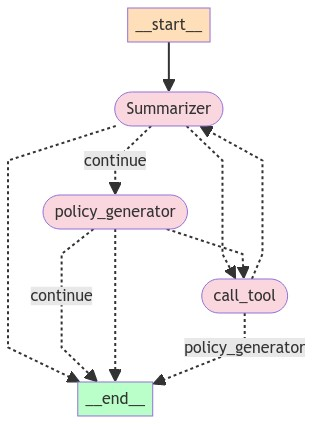

In [71]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass




In [72]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Get me the compliance criteria, eligibility criteria,"
                "financial requirements, fees, financial options for a retrofit project in California"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'Summarizer': {'messages': [AIMessage(content="['compliance criteria for a retrofit project in California', 'eligibility criteria for a retrofit project in California', 'financial requirements for a retrofit project in California', 'fees for a retrofit project in California', 'financial options for a retrofit project in California']", response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 159, 'total_tokens': 210}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ce0793330f', 'finish_reason': 'stop', 'logprobs': None}, name='Summarizer', id='run-1bac51e1-0210-4501-8f9a-ab4af0938c57-0', usage_metadata={'input_tokens': 159, 'output_tokens': 51, 'total_tokens': 210})], 'sender': 'Summarizer'}}
----
{'policy_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MhUWzsECZVHtbClfLB3SDO90', 'function': {'arguments': '{"query": ["compliance criteria for a retrofit project in California"]}', 'name': 'report_tool'}, 'typ